## Python functionalities

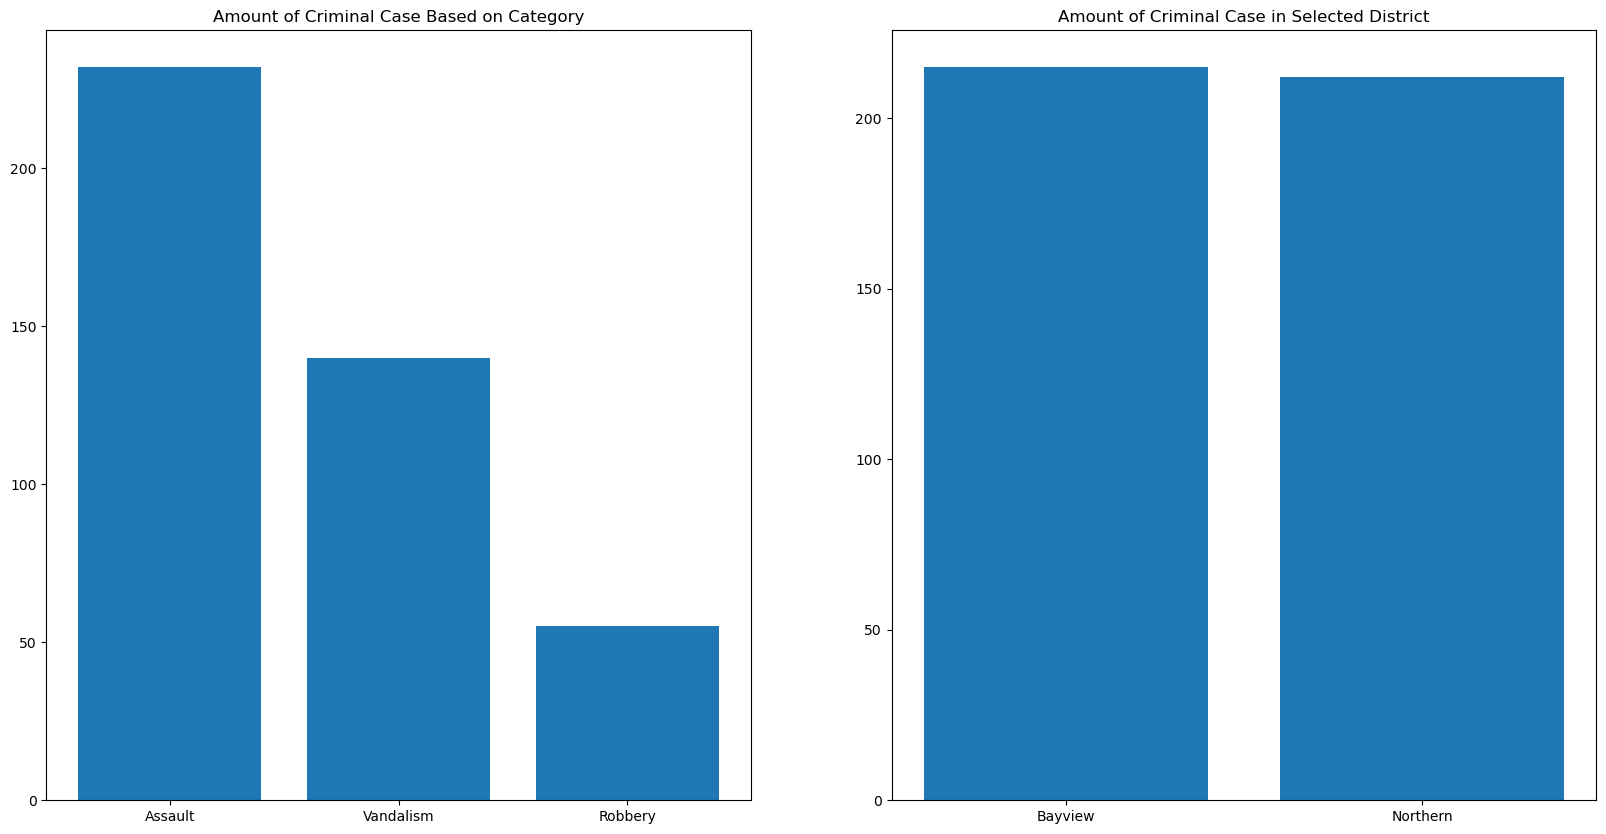

In [1]:
import pandas as pd
from pathlib import Path
import solara
import matplotlib.pyplot as plt
import folium
import folium.plugins
import solara

def crime_filter(df, district_values, category_values):
    df_dist = df.loc[df["PdDistrict"].isin(district_values)]
    df_category = df_dist.loc[df_dist["Category"].isin(category_values)]
    return df_category

def crime_charts(df):
    cat_unique = df["Category"].value_counts()
    cat_unique = cat_unique.reset_index()

    dist_unique = df["PdDistrict"].value_counts()
    dist_unique = dist_unique.reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.bar(cat_unique["Category"], cat_unique["count"])
    ax1.set_title("Amount of Criminal Case Based on Category")
    ax2.bar(dist_unique["PdDistrict"], dist_unique["count"])
    ax2.set_title("Amount of Criminal Case in Selected District")

    display(fig)
    plt.close(fig)

def crime_map(df):
    latitude = 37.77
    longitude = -122.42

    sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

    incidents = folium.plugins.MarkerCluster().add_to(sanfran_map)

    # loop through the dataframe and add each data point to the mark cluster
    for (
        lat,
        lng,
        label,
    ) in zip(df.Y, df.X, df.Category):
        folium.Marker(
            location=[lat, lng],
            icon=None,
            popup=label,
        ).add_to(incidents)

    # show map
    display(sanfran_map)


path = r'C:\Users\fuentesm\Projects\IDP\Data\Input\Geodata\solara\SF_crime_sample\SF_crime_sample.csv'
df_crime = pd.read_csv(path)

df_crime["Category"] = df_crime["Category"].str.title()
df_crime["PdDistrict"] = df_crime["PdDistrict"].str.title()
df_crime

dff_crime = crime_filter(df_crime, ["Bayview", "Northern"], ["Vandalism", "Assault", "Robbery"])
crime_charts(dff_crime)
crime_map(dff_crime.iloc[0:50, :])

## Solara app

#### Defining reactive variables

In [2]:
districts = solara.reactive(
    ["Bayview", "Northern"],
)
categories = solara.reactive(["Vandalism", "Assault", "Robbery"])
limit = solara.reactive(100)

#### Visualize components

In [3]:
@solara.component
def View():
    dff = crime_filter(df_crime, districts.value, categories.value)
    row_count = len(dff)
    if row_count > limit.value:
        solara.Warning(f"Only showing the first {limit.value} of {row_count:,} crimes on map")
    crime_map(dff.iloc[: limit.value])
    if row_count > 0:
        crime_charts(dff)
    else:
        solara.Warning("You filtered out all the data, no charts shown")
View()

Cannot show ipywidgets in text

#### Update variables 

In [4]:
limit.value = 70
districts.value = ["Soutern", "Northern"]

#### Adding controls 

In [5]:
solara.SelectMultiple("District", all_values=[str(k) for k in df_crime["PdDistrict"].unique().tolist()], values=districts)

Cannot show ipywidgets in text

In [6]:
@solara.component
def Controls():
    solara.SelectMultiple("District", all_values=[str(k) for k in df_crime["PdDistrict"].unique().tolist()], values=districts)
    solara.SelectMultiple("Category", all_values=[str(k) for k in df_crime["Category"].unique().tolist()], values=categories)
    solara.Text("Maximum number of rows to show on map")
    solara.SliderInt("", value=limit, min=1, max=1000)

Controls()

Cannot show ipywidgets in text

#### Update variables though the python code

In [7]:
# Note that we can read AND write reactive variables
categories.value = [*categories.value, "Warrants"]

#### Combining the components

In [8]:
@solara.component
def Page():
    with solara.Sidebar():
        Controls()
    View()


Page()

Cannot show ipywidgets in text